## Import Library

In this section, we import the libraries we used in our modeling project

In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow import keras

## Download Dataset

In this section we download our dataset on the kaggle web. we put the dataset on the kaggle web because according to our group, downloading the dataset via the kaggle web is much easier

In [ ]:
!chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && mv kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d nadyanurfadhila/indonesia-endangered-animal-species

 97% 654M/675M [00:04<00:00, 170MB/s]
100% 675M/675M [00:05<00:00, 140MB/s]


In [ ]:
!unzip -q /content/indonesia-endangered-animal-species.zip \
  && rm indonesia-endangered-animal-species.zip

## Organizing Dataset

We use a splitfolder library to separate training data, testing data, and validation data with composition (70% 20% 10%)

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
input_folder='/content/Cleaned Endangered Animal'

splitfolders.ratio(input_folder, output="Cleaned Endangered Animal3",
                   seed=42, ratio=(.7,.2,.1),
                  group_prefix=None)

Copying files: 979 files [00:02, 446.18 files/s]


### Train Val Generator

we created an imagedatagen and also implemented image augmentation because the data that we have is still relatively small.

In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class 
  # Don't forget to normalize pixel values and set arguments to augment the images 
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 45,
                                   width_shift_range = 0.25,
                                   height_shift_range = 0.25,
                                   shear_range = 0.25,
                                   zoom_range = 0.5,
                                   fill_mode = 'nearest',
                                   horizontal_flip = True)

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32, 
                                                      class_mode='categorical',
                                                      target_size=(224, 224),
                                                      shuffle = True)

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
  validation_datagen = ImageDataGenerator(rescale = 1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32, 
                                                                class_mode='categorical',
                                                                target_size=(224, 224))
  ### END CODE HERE
  return train_generator, validation_generator

we declare the directory of our training and validation dataset

In [ ]:
TRAINING_DIR = '/content/Cleaned Endangered Animal3/train'
VALIDATION_DIR = '/content/Cleaned Endangered Animal3/test'

train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 684 images belonging to 6 classes.
Found 103 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_dataset = image_dataset_from_directory(TRAINING_DIR,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(224,224))

Found 684 files belonging to 6 classes.


In [ ]:
class_names = train_dataset.class_names

print(class_names)

['Bekantan', 'Beruang Madu', 'Burung', 'Gajah Asia', 'Macan Tutul', 'Tapir']


In [ ]:
from pathlib import Path
import imghdr

data_dir = "/content/Cleaned Endangered Animal3/"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

## Simple CNN

the first thing that our group do is making a model for image detection. we use CNN with Keras's Library to make our model.

In this model we use 4 Conv2D layers with relu activation and then we flatten it and connect to our dense layer that have 6 class with softmax activation.

In [ ]:
import tensorflow as tf
from tensorflow import keras
model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

We train our model with Adam optimazer and 0.0001 learning rate and we use categorical crossentropy loss function because we implamanting a multiclass problem.

In [ ]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    epochs=60,
                    steps_per_epoch=2,
                    validation_data=validation_generator,
                    verbose = 2,
                    validation_steps=2)

In this section we show the graphic of accuracy in our first model. as you guys can see. the graph of the accuracy shows that our model is slightly over-fitting. but have a good accuracy (accuracy peak is 65%). because of this, our team decide to use transfer learning name Xception.

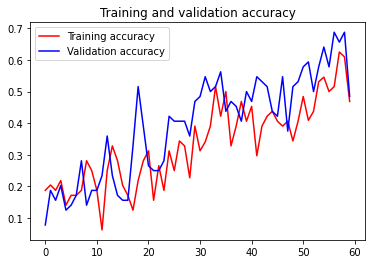

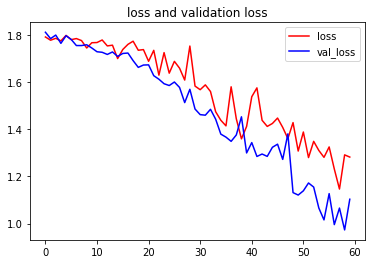

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('loss and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

## Transfer Learning

for the second model, we implamenting the transfer learning named Xception

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5\
    -O /content/Xception_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-05-31 09:56:47--  https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 173.194.210.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83683744 (80M) [application/octet-stream]
Saving to: ‘/content/Xception_weights_tf_dim_ordering_tf_kernels_notop.h5’

/content/Xception_w 100%[===================>]  79.81M   277MB/s    in 0.3s    

2022-05-31 09:56:47 (277 MB/s) - ‘/content/Xception_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [83683744/83683744]



In [ ]:
from tensorflow.keras.applications.xception import Xception

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/content/Xception_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
def create_pre_trained_model(local_weights_file):

  pre_trained_model = tf.keras.applications.xception.Xception(weights='imagenet', 
                              include_top=False, 
                              input_shape=(224, 224, 3))

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layers in pre_trained_model.layers:
    layers.trainable = False



  return pre_trained_model

we print the xception model summary

In [ ]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                   

We declare our callbacks function

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=0.95):
      print("\nReached 95.9% accuracy so cancelling training!")
      self.model.stop_training = True

we choose the frozen layer that we want to use in our model. in this case we use "add_10" layer

In [ ]:
def output_of_last_layer(pre_trained_model):
  
  last_desired_layer = pre_trained_model.get_layer('add_10')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)
  
  

  return last_output

In [ ]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 14, 14, 728)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 728), dtype=tf.float32, name=None), name='add_10/add:0', description="created by layer 'add_10'")


In [ ]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


we add our architecture like we flatten it first and the we add dense layer and the multiclass dense layer with softmax activation. after that we compile it with adam optimazer and low learning rate (0.0001) and use categorical crossentropy loss function.

In [ ]:
x = keras.layers.Flatten()(last_output)
x = keras.layers.Dense (512, activation='relu')(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense (6, activation='softmax')(x) 
model2 = Model(pre_trained_model.input, x)
model2.summary()

model2.compile(optimizer=keras.optimizers.Adam(0.0001),  # Low learning rate
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

we train our model with 50 epoch and 10 epoch per steps.

In [ ]:
callbacks = myCallback()
history = model2.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 50,
                    steps_per_epoch=10,
                    verbose = 2,
                    callbacks = [callbacks]
                    )

Epoch 1/50
10/10 - 100s - loss: 81.8990 - accuracy: 0.2313 - val_loss: 30.6776 - val_accuracy: 0.2816 - 100s/epoch - 10s/step
Epoch 2/50
10/10 - 89s - loss: 21.2141 - accuracy: 0.2800 - val_loss: 4.5027 - val_accuracy: 0.6505 - 89s/epoch - 9s/step
Epoch 3/50
10/10 - 88s - loss: 7.1274 - accuracy: 0.4133 - val_loss: 2.0029 - val_accuracy: 0.7087 - 88s/epoch - 9s/step
Epoch 4/50
10/10 - 93s - loss: 1.9110 - accuracy: 0.5500 - val_loss: 0.5680 - val_accuracy: 0.8350 - 93s/epoch - 9s/step
Epoch 5/50
10/10 - 94s - loss: 1.1208 - accuracy: 0.5469 - val_loss: 0.7869 - val_accuracy: 0.6699 - 94s/epoch - 9s/step
Epoch 6/50
10/10 - 89s - loss: 1.0783 - accuracy: 0.5767 - val_loss: 0.5225 - val_accuracy: 0.7767 - 89s/epoch - 9s/step
Epoch 7/50
10/10 - 93s - loss: 0.9143 - accuracy: 0.6250 - val_loss: 0.4566 - val_accuracy: 0.8252 - 93s/epoch - 9s/step
Epoch 8/50
10/10 - 113s - loss: 0.7918 - accuracy: 0.6844 - val_loss: 0.4590 - val_accuracy: 0.8155 - 113s/epoch - 11s/step
Epoch 9/50
10/10 - 90s 

ass you can see, we got a better accuracy with Xception transfer learning model but still quiet overfitting because we use the small dataset.

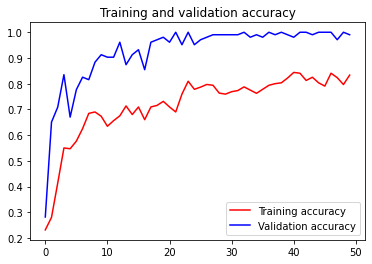

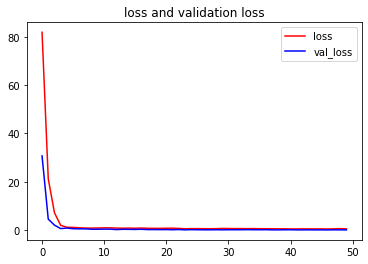

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('loss and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

## Fine Tuning

we unfreeze the pre trained model and compile again with adam optimizer and low learning rate (0.00001). 

In [ ]:
from tensorflow import keras
pre_trained_model.trainable = True


model2.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
                loss = keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics = ['accuracy']
)

epochs = 5
model2.fit(train_generator,
           validation_data=validation_generator,
          epochs=epochs 
         )

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


22/22 [==============================] - 565s 25s/step - loss: 0.5903 - accuracy: 0.7632 - val_loss: 0.0474 - val_accuracy: 1.0000
Epoch 2/5
22/22 [==============================] - 551s 26s/step - loss: 0.4130 - accuracy: 0.8348 - val_loss: 0.0366 - val_accuracy: 1.0000
Epoch 3/5
22/22 [==============================] - 548s 25s/step - loss: 0.4341 - accuracy: 0.8187 - val_loss: 0.0309 - val_accuracy: 1.0000
Epoch 4/5
22/22 [==============================] - 549s 25s/step - loss: 0.4039 - accuracy: 0.8465 - val_loss: 0.0354 - val_accuracy: 1.0000
Epoch 5/5
22/22 [==============================] - 550s 25s/step - loss: 0.3977 - accuracy: 0.8421 - val_loss: 0.0206 - val_accuracy: 1.0000


## Testing

Saving 10.jpg to 10.jpg
Saving 11.jpg to 11.jpg
Saving 12.jpg to 12.jpg
Saving 13.jpg to 13.jpg
Saving 14.jpg to 14.jpg


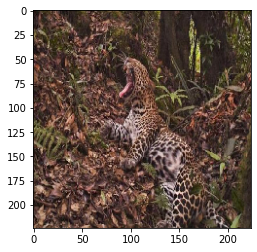

Bekantan: 6.86%
Beruang Madu: 3.69%
Burung: 0.36%
Gajah Asia: 1.02%
Macan Tutul: 87.49%
Tapir: 0.59%

Result: 
Macan Tutul: 87.49%


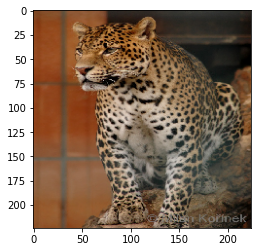

Bekantan: 0.00%
Beruang Madu: 0.00%
Burung: 0.00%
Gajah Asia: 0.00%
Macan Tutul: 100.00%
Tapir: 0.00%

Result: 
Macan Tutul: 100.00%


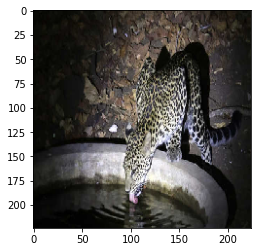

Bekantan: 6.20%
Beruang Madu: 3.11%
Burung: 11.36%
Gajah Asia: 5.62%
Macan Tutul: 72.50%
Tapir: 1.22%

Result: 
Macan Tutul: 72.50%


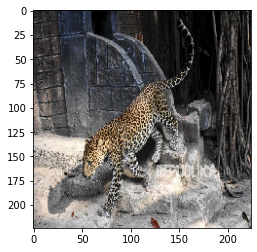

Bekantan: 0.33%
Beruang Madu: 0.05%
Burung: 0.32%
Gajah Asia: 1.13%
Macan Tutul: 98.15%
Tapir: 0.02%

Result: 
Macan Tutul: 98.15%


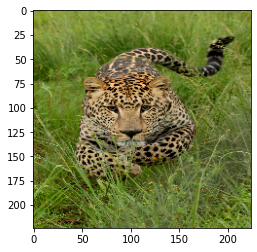

Bekantan: 0.07%
Beruang Madu: 0.00%
Burung: 0.01%
Gajah Asia: 0.19%
Macan Tutul: 99.73%
Tapir: 0.00%

Result: 
Macan Tutul: 99.73%


In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input
labels = train_generator.class_indices.keys()
uploaded = files.upload()

#for paths in uploaded.keys():
 
  # predicting images
for paths in uploaded.keys():
  path = paths
  img = image.load_img(path,target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  images = np.vstack([x])
  proba = model2.predict(images)[0]
  maxx = proba.max()
  plt.imshow(img)
  plt.show()
  for (label, p) in zip(labels, proba):
      print("{}: {:.2f}%".format(label, p * 100))
  for (label, p) in zip(labels, proba):
      if p <= 0.4:
        continue
      elif p == maxx:
          if p<=0.4:
              continue
          elif p>= 0.5:
              print('\nResult: ')
              print(("{}: {:.2f}%".format(label, p* 100)))
          else:
              print('\nHewan ini tidak terdeteksi!')

## Deploy and Download Model

In [ ]:
import pickle

In [ ]:
with open('sa-lindungi_fix', 'wb') as f:
    pickle.dump(model2,f)

INFO:tensorflow:Assets written to: ram://5814158e-23a4-4767-970b-02486e8d283d/assets


In [ ]:
def download_model():
  import pickle
  from google.colab import files

  with open('model_fix.pkl', 'wb') as f:
    pickle.dump(model2, f)

  files.download('model_fix.pkl')

download_model()

In [ ]:
# EXERCISE: Save the trained model as a Keras HDF5 file. 

saved_model_path = "./my_model_fix.h5"

model2.save(saved_model_path)

In [ ]:
files.download('my_model_fix.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>